In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Concatenate, Conv1D, GlobalMaxPooling1D, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model

# Data Preprocessing
def preprocess_data(df):
    event_type_mapping = df['event_type'].astype('category').cat.categories
    agent_id_mapping = df['agent_id'].astype('category').cat.categories
    context_mapping = df['context'].astype('category').cat.categories

    df['event_type'] = df['event_type'].astype('category').cat.codes
    df['agent_id'] = df['agent_id'].astype('category').cat.codes
    df['context'] = df['context'].astype('category').cat.codes

    return df, event_type_mapping, agent_id_mapping, context_mapping

# Load your dataset
df = pd.read_csv('1k_single_agent_minmax.csv')
df, event_type_mapping, agent_id_mapping, context_mapping = preprocess_data(df)

# Define constants
num_classes = df['event_type'].nunique()
num_agents = df['agent_id'].nunique()
num_contexts = df['context'].nunique()
sequence_length = 10  # Adjust based on your data
num_features = df.shape[1]  # Number of features

# Create sequences for training
def create_sequences(df, sequence_length):
    sequences = []
    for i in range(len(df) - sequence_length):
        seq = df.iloc[i:i+sequence_length].values
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(df, sequence_length)

# Splitting the data
train_size = int(0.7 * len(sequences))
val_size = int(0.15 * len(sequences))
train_sequences = sequences[:train_size]
val_sequences = sequences[train_size:train_size+val_size]
test_sequences = sequences[train_size+val_size:]

# Extract targets
def extract_targets(sequences):
    next_event = to_categorical(sequences[:, -1, 0], num_classes=num_classes)
    agent = to_categorical(sequences[:, -1, 1], num_classes=num_agents)
    context = to_categorical(sequences[:, -1, 2], num_classes=num_contexts)
    anomaly = np.random.randint(0, 2, size=(sequences.shape[0], 1))  # Placeholder for anomaly
    return next_event, agent, context, anomaly

train_targets = extract_targets(train_sequences)
val_targets = extract_targets(val_sequences)
test_targets = extract_targets(test_sequences)

# Define the model branches
def lstm_branch(input_shape):
    inputs = Input(shape=(input_shape[0],))
    x = Embedding(input_dim=num_classes, output_dim=64)(inputs)
    x = LSTM(128, return_sequences=False)(x)
    return inputs, x

def gru_branch(input_shape):
    inputs = Input(shape=(input_shape[0],))
    x = Embedding(input_dim=num_classes, output_dim=64)(inputs)
    x = GRU(128, return_sequences=False)(x)
    return inputs, x

def transformer_branch(input_shape):
    inputs = Input(shape=(input_shape[0],))
    x = Embedding(input_dim=num_classes, output_dim=64)(inputs)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x + attn_output)
    x = GlobalMaxPooling1D()(x)  # Apply GlobalMaxPooling1D to convert 3D to 2D
    return inputs, x

def convnet_branch(input_shape):
    inputs = Input(shape=(input_shape[0],))
    x = Embedding(input_dim=num_classes, output_dim=64)(inputs)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    return inputs, x

# Build the model
def build_model(sequence_length):
    # Define the branches for each input
    lstm_event_inputs, lstm_event_output = lstm_branch((sequence_length,))
    lstm_agent_inputs, lstm_agent_output = lstm_branch((sequence_length,))
    lstm_context_inputs, lstm_context_output = lstm_branch((sequence_length,))
    
    gru_event_inputs, gru_event_output = gru_branch((sequence_length,))
    gru_agent_inputs, gru_agent_output = gru_branch((sequence_length,))
    gru_context_inputs, gru_context_output = gru_branch((sequence_length,))
    
    transformer_event_inputs, transformer_event_output = transformer_branch((sequence_length,))
    transformer_agent_inputs, transformer_agent_output = transformer_branch((sequence_length,))
    transformer_context_inputs, transformer_context_output = transformer_branch((sequence_length,))
    
    convnet_event_inputs, convnet_event_output = convnet_branch((sequence_length,))
    convnet_agent_inputs, convnet_agent_output = convnet_branch((sequence_length,))
    convnet_context_inputs, convnet_context_output = convnet_branch((sequence_length,))
    
    # Concatenate outputs from all branches
    concatenated = Concatenate()([
        lstm_event_output, lstm_agent_output, lstm_context_output,
        gru_event_output, gru_agent_output, gru_context_output,
        transformer_event_output, transformer_agent_output, transformer_context_output,
        convnet_event_output, convnet_agent_output, convnet_context_output
    ])
    
    shared_dense = Dense(128, activation='relu')(concatenated)
    
    next_event_head = Dense(num_classes, activation='softmax', name='next_event')(shared_dense)
    agent_head = Dense(num_agents, activation='softmax', name='agent')(shared_dense)
    context_head = Dense(num_contexts, activation='softmax', name='context')(shared_dense)
    anomaly_head = Dense(1, activation='sigmoid', name='anomaly')(shared_dense)
    
    model = Model(inputs=[
        lstm_event_inputs, lstm_agent_inputs, lstm_context_inputs,
        gru_event_inputs, gru_agent_inputs, gru_context_inputs,
        transformer_event_inputs, transformer_agent_inputs, transformer_context_inputs,
        convnet_event_inputs, convnet_agent_inputs, convnet_context_inputs
    ], outputs=[next_event_head, agent_head, context_head, anomaly_head])
    
    return model

input_shape = (sequence_length,)
model = build_model(sequence_length)

# Compile the model
model.compile(optimizer='adam',
              loss={'next_event': 'categorical_crossentropy', 
                    'agent': 'categorical_crossentropy',
                    'context': 'categorical_crossentropy', 
                    'anomaly': 'binary_crossentropy'},
              loss_weights={'next_event': 1.0, 'agent': 0.5, 'context': 0.5, 'anomaly': 0.1},
              metrics={'next_event': 'accuracy', 
                       'agent': 'accuracy',
                       'context': 'accuracy',
                       'anomaly': 'accuracy'})

# Training the model
history = model.fit(
    [train_sequences[:,:,0], train_sequences[:,:,1], train_sequences[:,:,2],
     train_sequences[:,:,0], train_sequences[:,:,1], train_sequences[:,:,2],
     train_sequences[:,:,0], train_sequences[:,:,1], train_sequences[:,:,2],
     train_sequences[:,:,0], train_sequences[:,:,1], train_sequences[:,:,2]],
    {'next_event': train_targets[0], 'agent': train_targets[1], 'context': train_targets[2], 'anomaly': train_targets[3]},
    validation_data=(
        [val_sequences[:,:,0], val_sequences[:,:,1], val_sequences[:,:,2],
         val_sequences[:,:,0], val_sequences[:,:,1], val_sequences[:,:,2],
         val_sequences[:,:,0], val_sequences[:,:,1], val_sequences[:,:,2],
         val_sequences[:,:,0], val_sequences[:,:,1], val_sequences[:,:,2]],
        {'next_event': val_targets[0], 'agent': val_targets[1], 'context': val_targets[2], 'anomaly': val_targets[3]}
    ),
    epochs=50, batch_size=64
)

history_df = pd.DataFrame(history.history)
history_df.to_csv('training_results/RNN_Combine_model_GRU.csv', index=False)
# Evaluate the model
eval_results = model.evaluate(
    [test_sequences[:,:,0], test_sequences[:,:,1], test_sequences[:,:,2],
     test_sequences[:,:,0], test_sequences[:,:,1], test_sequences[:,:,2],
     test_sequences[:,:,0], test_sequences[:,:,1], test_sequences[:,:,2],
     test_sequences[:,:,0], test_sequences[:,:,1], test_sequences[:,:,2]],
    {'next_event': test_targets[0], 'agent': test_targets[1], 'context': test_targets[2], 'anomaly': test_targets[3]}
)
print(f"Test Loss and Accuracy: {eval_results}")


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 63s 441ms/step - agent_accuracy: 0.3390 - anomaly_accuracy: 0.5092 - context_accuracy: 0.0878 - loss: 2.6997 - next_event_accuracy: 0.7795 - val_agent_accuracy: 0.4459 - val_anomaly_accuracy: 0.4932 - val_context_accuracy: 0.0676 - val_loss: 2.3837 - val_next_event_accuracy: 0.7973
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - agent_accuracy: 0.4691 - anomaly_accuracy: 0.5821 - context_accuracy: 0.1248 - loss: 2.2219 - next_event_accuracy: 0.8327 - val_agent_accuracy: 0.5405 - val_anomaly_accuracy: 0.5000 - val_context_accuracy: 0.1351 - val_loss: 1.9222 - val_next_event_accuracy: 0.9392
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - agent_accuracy: 0.6729 - anomaly_accuracy: 0.5436 - context_accuracy: 0.1614 - loss: 1.7638 - next_event_accuracy: 0.9650 - val_agent_accuracy: 0.7568 - val_anomaly_accuracy: 0.5405 - val_context_accuracy: 0.2230 - val_loss: 1.4515 - val_next_event_accuracy: 1.0000
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [2]:
num_samples = 10
sample_sequences = test_sequences[:num_samples]

# Predict the next values
predictions = model.predict(
    [sample_sequences[:,:,0], sample_sequences[:,:,1], sample_sequences[:,:,2],
     sample_sequences[:,:,0], sample_sequences[:,:,1], sample_sequences[:,:,2],
     sample_sequences[:,:,0], sample_sequences[:,:,1], sample_sequences[:,:,2]]
)

# Extract predictions
next_event_predictions = np.argmax(predictions[0], axis=-1)
agent_predictions = np.argmax(predictions[1], axis=-1)
context_predictions = np.argmax(predictions[2], axis=-1)
anomaly_predictions = (predictions[3] > 0.5).astype(int)

# Decode predictions
def decode_predictions(predictions, id_to_label):
    return [id_to_label[idx] for idx in predictions]

decoded_next_event_predictions = decode_predictions(next_event_predictions, event_type_mapping)
decoded_agent_predictions = decode_predictions(agent_predictions, agent_id_mapping)
decoded_context_predictions = decode_predictions(context_predictions, context_mapping)

# Decode input sequences
def decode_sequences(sequences, event_mapping, agent_mapping, context_mapping):
    decoded_sequences = []
    for seq in sequences:
        decoded_seq = []
        for step in seq:
            decoded_step = [
                event_mapping[step[0]],
                agent_mapping[step[1]],
                context_mapping[step[2]]
            ]
            decoded_seq.append(decoded_step)
        decoded_sequences.append(decoded_seq)
    return np.array(decoded_sequences)

decoded_sample_sequences = decode_sequences(sample_sequences, event_type_mapping, agent_id_mapping, context_mapping)

# Print decoded input sequences and predictions
for i in range(num_samples):
    print(f"Input sequence (event_id, agent_id, context):\n{decoded_sample_sequences[i]}")
    print(f"Predicted next event_id: {decoded_next_event_predictions[i]}")
    print(f"Predicted next agent_id: {decoded_agent_predictions[i]}")
    print(f"Predicted next context: {decoded_context_predictions[i]}")
    print(f"Predicted anomaly: {anomaly_predictions[i]}")
    print("-" * 30)

ValueError: Layer 'functional_1' expected 12 input(s). Received 9 instead.

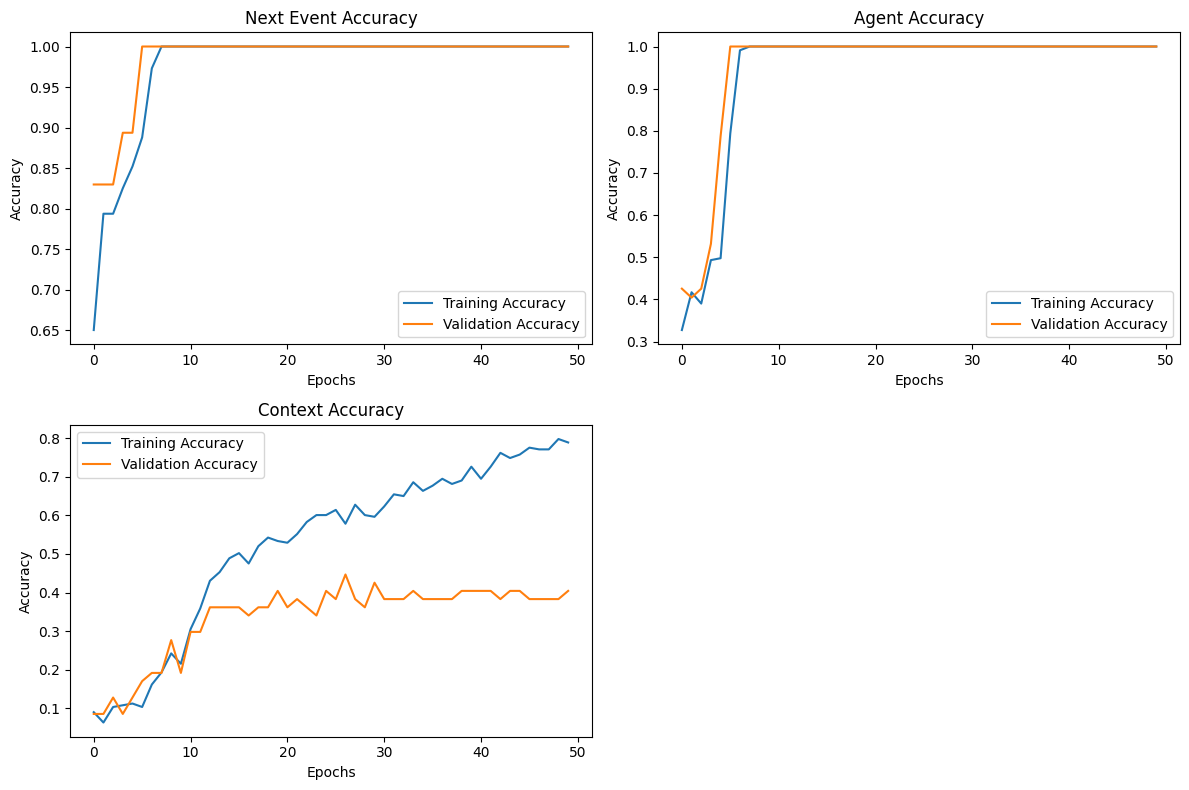

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
history_df = pd.read_csv('training_results/RNN_Combine_model_GRU.csv')

# Plot the training and validation accuracy for each task
plt.figure(figsize=(12, 8))

# Plot for next_event accuracy
plt.subplot(2, 2, 1)
plt.plot(history_df['next_event_accuracy'], label='Training Accuracy')
plt.plot(history_df['val_next_event_accuracy'], label='Validation Accuracy')
plt.title('Next Event Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for agent accuracy
plt.subplot(2, 2, 2)
plt.plot(history_df['agent_accuracy'], label='Training Accuracy')
plt.plot(history_df['val_agent_accuracy'], label='Validation Accuracy')
plt.title('Agent Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for context accuracy
plt.subplot(2, 2, 3)
plt.plot(history_df['context_accuracy'], label='Training Accuracy')
plt.plot(history_df['val_context_accuracy'], label='Validation Accuracy')
plt.title('Context Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def get_user_input(prompt, valid_options):
    while True:
        user_input = input(prompt).strip()
        if user_input in valid_options:
            return user_input
        print(f"Invalid input. Please choose from: {', '.join(valid_options)}")

def play_game(model, event_type_mapping, agent_id_mapping, context_mapping, sequence_length=10):
    sequence = []
    
    print("Let's start the game!")
    print(f"You'll provide the context for each step. The model will predict the event and agent.")
    print(f"We'll play for {sequence_length} steps.")
    
    for step in range(sequence_length):
        print(f"\nStep {step + 1}:")
        
        # Get context input from user
        context_options = list(context_mapping)
        context = get_user_input("Enter the context: ", context_options)
        context_id = np.where(context_mapping == context)[0][0]
        
        # If we don't have enough history, use placeholder values
        if len(sequence) < 3:
            event_id = 0
            agent_id = 0
        else:
            # Prepare input for model
            model_input = np.array(sequence[-3:])
            model_input = np.expand_dims(model_input, axis=0)
            
            # Make predictions
            predictions = model.predict([model_input[:,:,0], model_input[:,:,1], model_input[:,:,2],
                                         model_input[:,:,0], model_input[:,:,1], model_input[:,:,2],
                                         model_input[:,:,0], model_input[:,:,1], model_input[:,:,2]])
            
            # Extract predictions
            event_id = np.argmax(predictions[0][0])
            agent_id = np.argmax(predictions[1][0])
        
        # Decode predictions
        predicted_event = event_type_mapping[event_id]
        predicted_agent = agent_id_mapping[agent_id]
        
        print(f"Model predicts:")
        print(f"Event: {predicted_event}")
        print(f"Agent: {predicted_agent}")
        
        # Add to sequence
        sequence.append([event_id, agent_id, context_id])
    
    print("\nGame over! Thanks for playing.")

# Start the game
play_game(model, event_type_mapping, agent_id_mapping, context_mapping)

Let's start the game!
You'll provide the context for each step. The model will predict the event and agent.
We'll play for 5 steps.

Step 1:
